In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def criar_grafo_orientacao(caminho_arquivo):
    try:
        # Carregar o arquivo CSV
        # Carregar os dados do arquivo CSV, especificando a codificação
        df = pd.read_csv(caminho_arquivo, sep=';', encoding='latin-1')

        # Selecionar apenas as colunas relevantes e remover linhas com dados faltantes
        colunas_necessarias = ['DiscenteID', 'OrientadorID', 'Unidade', 'Codigo_Projeto']
        df_limpo = df[colunas_necessarias].dropna()

        # Criando uma chave única para cada combinação de DiscenteID, OrientadorID e Codigo_Projeto
        df_limpo['chave_unica'] = df_limpo['DiscenteID'].astype(str) + '_' + df_limpo['OrientadorID'].astype(str) + '_' + df_limpo['Codigo_Projeto'].astype(str)

        # Remover duplicatas com base nesta chave única
        df_processado = df_limpo.drop_duplicates(subset=['chave_unica']).copy()

        # Cria listas de identificadores únicos com prefixos, para evitar conflitos de nomes de nós no grafo
        discentes = ['discente_' + str(i) for i in df_processado['DiscenteID'].unique()]
        orientadores = ['orientador_' + str(i) for i in df_processado['OrientadorID'].unique()]
        departamentos = ['departamento_' + str(i) for i in df_processado['Unidade'].unique()]

        # Criando grafo
        G = nx.Graph()
        G.add_nodes_from(discentes, bipartite='discente')
        G.add_nodes_from(orientadores, bipartite='orientador')
        G.add_nodes_from(departamentos, bipartite='departamento')

        # Adicionando arestas com prefixos
        for _, row in df_processado.iterrows():
            G.add_edge(
                'discente_' + str(row['DiscenteID']),
                'orientador_' + str(row['OrientadorID']),
                tipo='orientacao'
            )

        # Arestas orientador <-> departamento
        pesos = df_processado.groupby(['OrientadorID', 'Unidade']).size().reset_index(name='peso')
        for _, row in pesos.iterrows():
            G.add_edge(
                'orientador_' + str(row['OrientadorID']),
                'departamento_' + str(row['Unidade']),
                peso=row['peso'],
                tipo='afiliacao'
            )

        # Imprimir informações sobre o grafo
        print(f"Número total de nós: {G.number_of_nodes()}")
        print(f"Número total de arestas: {G.number_of_edges()}")
        print(f"A densidade do grafo: {nx.density(G)}")
        return G # Retornar o grafo corrigido

    except FileNotFoundError:
        print(f"Erro: O arquivo '{caminho_arquivo}' não foi encontrado. Verifique o nome e o caminho do arquivo.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return None

# Exemplo de como usar a função com o seu arquivo
caminho_do_seu_arquivo = "./Iniciação_Ciêntifica - Dados Abertos.csv"
grafo_final = criar_grafo_orientacao(caminho_do_seu_arquivo)

Número total de nós: 28219
Número total de arestas: 33618
A densidade do grafo: 8.443723820245974e-05


Departamentos disponíveis:
1: departamento_ESCOLA DE MÚSICA - EMUFRN
2: departamento_DEPARTAMENTO DE ENGENHARIA QUIMICA - DEQ/CT
3: departamento_CENTRO DE CIÊNCIAS SOCIAIS APLICADAS - CCSA
4: departamento_DEPARTAMENTO DE CIÊNCIAS ADMINISTRATIVAS - DEPAD - DEPAD/CCSA
5: departamento_DEPARTAMENTO DE ENGENHARIA DE COMUNICAÇÕES - DCO/CT
6: departamento_CENTRO DE CIÊNCIAS EXATAS E DA TERRA - CCET
7: departamento_DEPARTAMENTO DE ESTATISTICA - EST/CCET
8: departamento_ESCOLA AGRÍCOLA DE JUNDIAÍ - EAJ
9: departamento_DEPARTAMENTO DE DIREITO PUBLICO - DIPUB - DPU/CCSA
10: departamento_DEPARTAMENTO DE FONOAUDIOLOGIA - DEPFONO
11: departamento_DEPARTAMENTO DE SAÚDE COLETIVA - DSC/CCS
12: departamento_CERES - DEPARTAMENTO DE GEOGRAFIA - DGC/CERES
13: departamento_DEPARTAMENTO DE SERVIÇO SOCIAL - DESSO - DESSO/CCSA
14: departamento_DEPARTAMENTO DE FUNDAMENTOS E POLÍTICAS DA EDUCAÇÃO - DFPE/CE
15: departamento_DEPARTAMENTO DE CIRURGIA - DCIRUR/CCS
16: departamento_DEPARTAMENTO DE ANÁLISES CLÍNICAS E

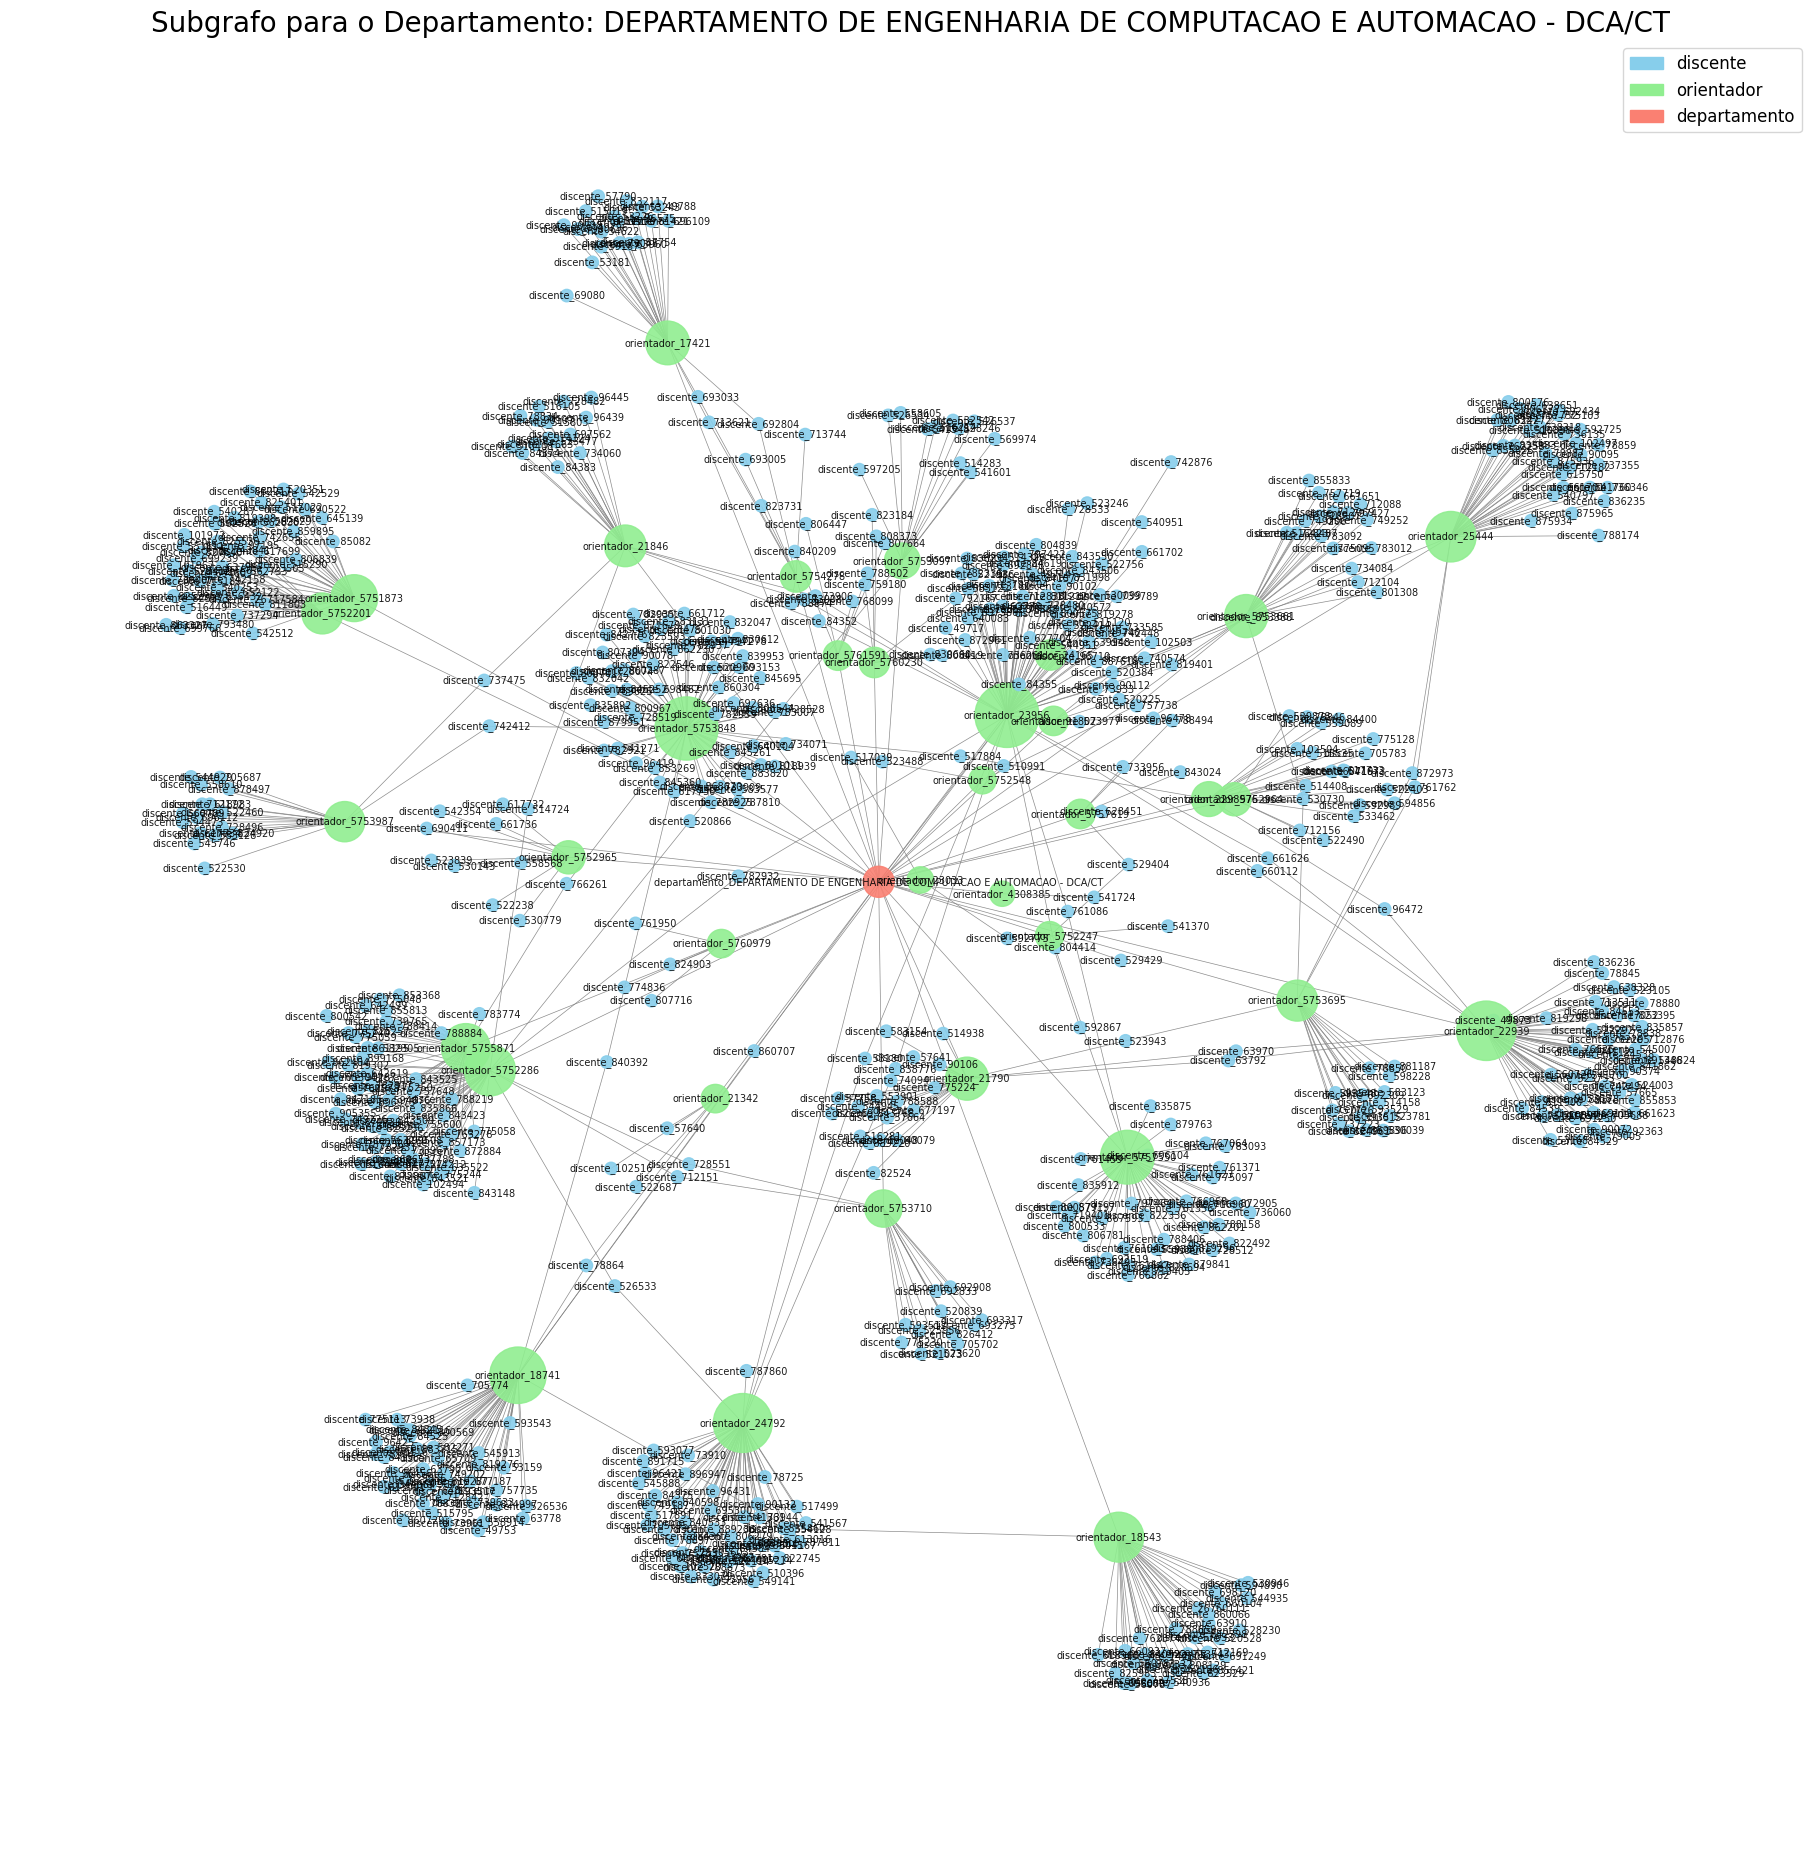

In [2]:
from matplotlib.patches import Patch 

# Obter a lista de departamentos do grafo
departamentos_grafo = [node for node, data in grafo_final.nodes(data=True) if data.get('bipartite') == 'departamento']

# Permitir que o usuário escolha o departamento de interesse
print("Departamentos disponíveis:")
for i, dep in enumerate(departamentos_grafo):
    print(f"{i+1}: {dep}")

escolha = input(f"Digite o número do departamento de interesse (1 a {len(departamentos_grafo)}): ")

try:
    indice_escolhido = int(escolha) - 1
    if 0 <= indice_escolhido < len(departamentos_grafo):
        departamento_interesse = departamentos_grafo[indice_escolhido]
        print(f"Departamento de interesse selecionado: {departamento_interesse}")
    else:
        departamento_interesse = None
        print("Escolha inválida.")
except ValueError:
    departamento_interesse = None
    print("Entrada inválida.")


# Filtrar o subgrafo
if departamento_interesse:
    # Identificar orientadores afiliados com o departamento de interesse
    orientadores_departamento = set()
    for u, v, data in grafo_final.edges(data=True):
        if data.get('tipo') == 'afiliacao' and (u == departamento_interesse or v == departamento_interesse):
            # O outro nó deve ser um orientador
            if grafo_final.nodes[u].get('bipartite') == 'orientador':
                orientadores_departamento.add(u)
            elif grafo_final.nodes[v].get('bipartite') == 'orientador':
                orientadores_departamento.add(v)

    # Identificar discentes orientados por esses orientadores
    discentes_orientados = set()
    for u, v, data in grafo_final.edges(data=True):
        if data.get('tipo') == 'orientacao':
            if u in orientadores_departamento and grafo_final.nodes[v].get('bipartite') == 'discente':
                discentes_orientados.add(v)
            elif v in orientadores_departamento and grafo_final.nodes[u].get('bipartite') == 'discente':
                discentes_orientados.add(u)

    # Criar uma lista de nós para o subgrafo
    nodes_subgrafo = [departamento_interesse] + list(orientadores_departamento) + list(discentes_orientados)

    # Gerar o subgrafo
    subgrafo_departamento = grafo_final.subgraph(nodes_subgrafo).copy() 

    print(f"Número de nós no subgrafo: {subgrafo_departamento.number_of_nodes()}")
    print(f"Número de arestas no subgrafo: {subgrafo_departamento.number_of_edges()}")
    print(f"A densidade do subgrafo: {nx.density(subgrafo_departamento)}")

    # Calcular o número de discentes por orientador no subgrafo
    discentes_por_orientador = {}
    for discente in discentes_orientados:
        for vizinho in subgrafo_departamento.neighbors(discente):
            if subgrafo_departamento.nodes[vizinho].get('bipartite') == 'orientador':
                discentes_por_orientador[vizinho] = discentes_por_orientador.get(vizinho, 0) + 1


    # Visualizar o subgrafo filtrado e Adicionar rótulos e legendas
    # Definir as cores para cada tipo de nó
    cores_mapa = {
        'discente': 'skyblue',
        'orientador': 'lightgreen',
        'departamento': 'salmon'
    }

    # Definir tamanhos dos nós
    tamanhos_nos = []
    for node in subgrafo_departamento.nodes():
        if subgrafo_departamento.nodes[node].get('bipartite') == 'orientador':
            # Aumentar o tamanho do nó do orientador com base no número de discentes
            tamanho = 300 + (discentes_por_orientador.get(node, 0) * 30)
            tamanhos_nos.append(tamanho)
        elif subgrafo_departamento.nodes[node].get('bipartite') == 'discente':
            tamanhos_nos.append(80) # Tamanho ligeiramente maior para discentes
        else:
            tamanhos_nos.append(500) # Tamanho maior para o departamento

    # Obter os tipos de nós do subgrafo e mapear para cores
    node_colors = [cores_mapa.get(subgrafo_departamento.nodes[node].get('bipartite'), 'gray') for node in subgrafo_departamento.nodes()]

    # Aqui podemos brincar um pouco com diferentes layouts! Teste agora mesmo!" 
    pos = nx.spring_layout(subgrafo_departamento, k= 0.7) # Ajuste o parâmetro k para espaçamento
    # pos = nx.kamada_kawai_layout(subgrafo_departamento)
    # pos = nx.random_layout(subgrafo_departamento) # Um layout aleatório para começar
    # pos = nx.circular_layout(subgrafo_departamento)

    # Configurar tamanho da figura
    plt.figure(figsize=(18, 18)) # Aumentar o tamanho da figura

    # Desenhar o grafo com rótulos
    nx.draw(subgrafo_departamento, pos, node_color=node_colors, node_size=tamanhos_nos,
            with_labels=True, font_size=7, alpha=0.9, edge_color='gray', width=0.5) # Ajustar fonte, transparência, cor e largura das arestas

    # Criar patches para a legenda
    legend_patches = [Patch(color=color, label=label) for label, color in cores_mapa.items()]

    # Adicionar a legenda
    plt.legend(handles=legend_patches, loc='best', fontsize=12) # Ajustar tamanho da fonte da legenda

    # Definir o título (removendo o prefixo "departamento_")
    nome_departamento = departamento_interesse.replace("departamento_", "")
    plt.title(f"Subgrafo para o Departamento: {nome_departamento}", fontsize=20) # Ajustar tamanho da fonte do título

    # Remover eixos
    plt.axis('off')

    # Exibir o plot
    plt.show()
else:
    print("Não foi possível gerar o subgrafo pois o departamento não foi selecionado ou é inválido.")

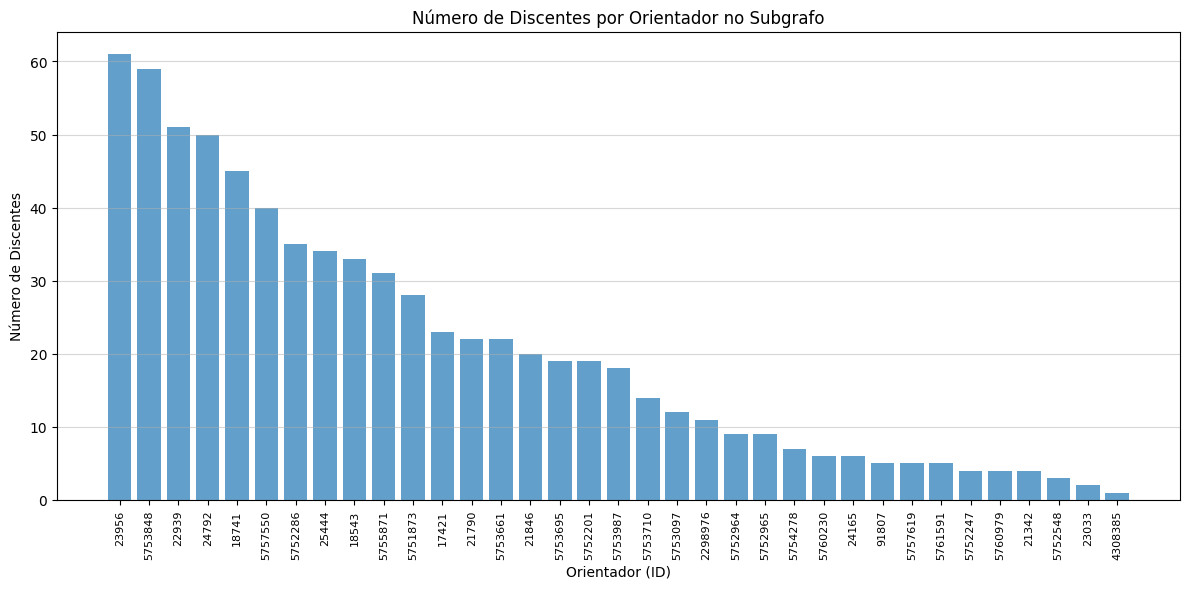


=== ANÁLISE DE DISTRIBUIÇÃO - DISCENTES (SUBGRAFO) ===
Total de Discentes: 677
Grau médio dos discentes: 1.06
Grau mínimo: 1
Grau máximo: 2

=== ANÁLISE DE DISTRIBUIÇÃO - PROFESSORES (SUBGRAFO) ===
Total de professores: 35
Número médio de orientandos: 20.49
Mínimo de orientandos: 1
Máximo de orientandos: 61


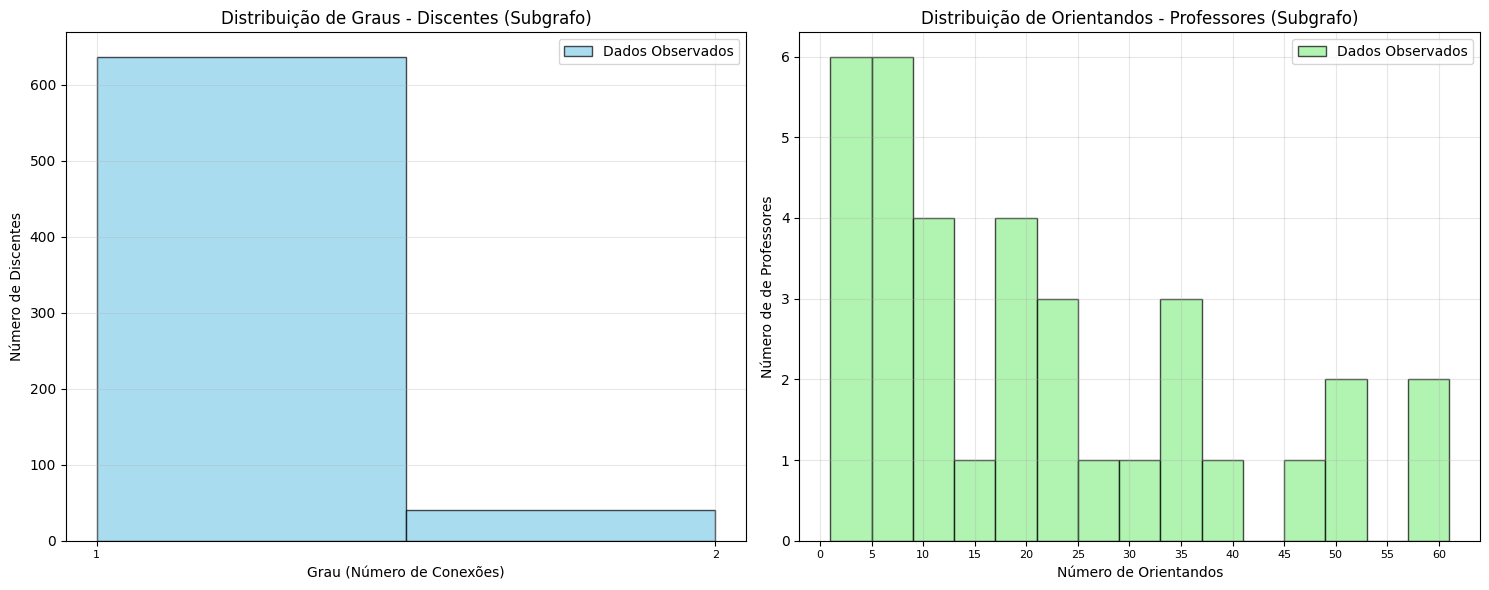

In [3]:
import collections

# Calcular o número de discentes por orientador para o gráfico de barras
discentes_por_orientador = {}
# Certifique-se de iterar sobre os nós do subgrafo que são orientadores
orientadores_no_subgrafo = [node for node, data in subgrafo_departamento.nodes(data=True) if data.get('bipartite') == 'orientador']

for orientador in orientadores_no_subgrafo:
    # Contar discentes conectados a este orientador no subgrafo
    count = 0
    for neighbor in subgrafo_departamento.neighbors(orientador):
        if subgrafo_departamento.nodes[neighbor].get('bipartite') == 'discente':
            count += 1
    discentes_por_orientador[orientador] = count

# Preparar dados para o gráfico de barras
orientadores_ids = list(discentes_por_orientador.keys())
numero_discentes = list(discentes_por_orientador.values())

# Ordenar os orientadores pelo número de discentes para uma melhor visualização no gráfico de barras
orientadores_ordenados, discentes_ordenados = zip(*sorted(zip(orientadores_ids, numero_discentes), key=lambda x: x[1], reverse=True))

# Remover o prefixo 'orientador_' dos IDs para exibição no gráfico
orientadores_labels = [oid.replace('orientador_', '') for oid in orientadores_ordenados]


# Criar o gráfico de barras (Orientadores x Discentes)
plt.figure(figsize=(12, 6)) # Aumentar o tamanho para acomodar mais barras
plt.bar(range(len(orientadores_ordenados)), discentes_ordenados, alpha=0.7)
plt.xlabel("Orientador (ID)")
plt.ylabel("Número de Discentes")
plt.title("Número de Discentes por Orientador no Subgrafo")
plt.xticks(range(len(orientadores_ordenados)), orientadores_labels, rotation=90, fontsize=8) # Rotacionar rótulos do eixo x e diminuir fonte
plt.tight_layout() # Ajustar layout para evitar sobreposição de rótulos
plt.grid(axis='y', alpha=0.5)
plt.show()

# Print de espaçamento
print()

# Análise de Distribuição Normal - Discentes e Professores do Subgrafo
import numpy as np
from scipy import stats

# Análise 1: Distribuição Normal para Discentes (grau de conexão) no subgrafo
# Calcular graus apenas dos discentes no subgrafo
graus_discentes_subgrafo = [subgrafo_departamento.degree(node) for node, data in subgrafo_departamento.nodes(data=True)
                           if data.get('bipartite') == 'discente']

# Estatísticas dos discentes no subgrafo
if graus_discentes_subgrafo:
    media_discentes_subgrafo = np.mean(graus_discentes_subgrafo)
    desvio_discentes_subgrafo = np.std(graus_discentes_subgrafo)

    print(f"=== ANÁLISE DE DISTRIBUIÇÃO - DISCENTES (SUBGRAFO) ===")
    print(f"Total de Discentes: {len(graus_discentes_subgrafo)}")
    print(f"Grau médio dos discentes: {media_discentes_subgrafo:.2f}")
    print(f"Grau mínimo: {min(graus_discentes_subgrafo)}")
    print(f"Grau máximo: {max(graus_discentes_subgrafo)}")
    print()

    # Análise 2: Distribuição Normal para Professores (número de orientandos) no subgrafo
    # Usar os dados já calculados de discentes_por_orientador
    orientandos_por_professor_subgrafo = list(discentes_por_orientador.values())

    if orientandos_por_professor_subgrafo:
        # Estatísticas dos professores no subgrafo
        media_professores_subgrafo = np.mean(orientandos_por_professor_subgrafo)
        desvio_professores_subgrafo = np.std(orientandos_por_professor_subgrafo)

        print(f"=== ANÁLISE DE DISTRIBUIÇÃO - PROFESSORES (SUBGRAFO) ===")
        print(f"Total de professores: {len(orientandos_por_professor_subgrafo)}")
        print(f"Número médio de orientandos: {media_professores_subgrafo:.2f}")
        print(f"Mínimo de orientandos: {min(orientandos_por_professor_subgrafo)}")
        print(f"Máximo de orientandos: {max(orientandos_por_professor_subgrafo)}")

        # Visualizações lado a lado
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Gráfico 1: Histograma - Discentes do Subgrafo
        ax1.hist(graus_discentes_subgrafo, bins=min(15, len(set(graus_discentes_subgrafo))), density=False, alpha=0.7, color='skyblue',
                 edgecolor='black', label='Dados Observados')

        ax1.set_title('Distribuição de Graus - Discentes (Subgrafo)')
        ax1.set_xlabel('Grau (Número de Conexões)')
        ax1.set_ylabel('Número de Discentes')
        ax1.set_xticks(range(int(min(graus_discentes_subgrafo)), int(max(graus_discentes_subgrafo)) + 1, 1))
        ax1.tick_params(axis='x', labelsize=8)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Gráfico 2: Histograma- Professores do Subgrafo
        ax2.hist(orientandos_por_professor_subgrafo, bins=min(15, len(set(orientandos_por_professor_subgrafo))), density=False, alpha=0.7, color='lightgreen',
                 edgecolor='black', label='Dados Observados')

        ax2.set_title('Distribuição de Orientandos - Professores (Subgrafo)')
        ax2.set_xlabel('Número de Orientandos')
        ax2.set_ylabel('Número de de Professores')

        # Ajustar escala do eixo x baseado no range dos dados
        if max(orientandos_por_professor_subgrafo) <= 20:
            ax2.set_xticks(range(int(min(orientandos_por_professor_subgrafo)), int(max(orientandos_por_professor_subgrafo)) + 1, 1))
        else:
            ax2.set_xticks(range(0, int(max(orientandos_por_professor_subgrafo)) + 1, 5))

        ax2.tick_params(axis='x', labelsize=8)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("Não há professores suficientes no subgrafo para análise de distribuição.")
else:
    print("Não há discentes suficientes no subgrafo para análise de distribuição.")